# Evaluate Improved Earring Label

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


## Settings

In [3]:
SAVE_NAME = 'vae.fixed_earring'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'

TEST_SIZE = 1000
EPOCHS = 500
LR = 1e-03
BATCH_SIZE = 32
LABELS_FILE = '../scripts/pallets_labels.json'


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
logger = L.init_logger(notebook=True)


## Load Environment

In [6]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../scripts/onehot_ds.pt')

dataset = torch.load('../scripts/onehot_ds.pt')

In [7]:
num_labels = len(dataset._labels[0])

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)



# The Model

This model builds off the VAE using in the previous notebook with a final call to gumbel-softmax, allow backprop to nudge the output of the decoder into place

In [8]:
# Train Model

latent_dims = 32
model = M.vae.LabeledVAE(222, (64, 32), latent_dims, num_labels)

criterion = M.vae.Loss()


In [9]:
logger.info("starting model training")

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | starting model training
INFO | model: pallets.models.vae.LabeledVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.001
INFO | epochs: 500
INFO | epoch 1 (  0%) loss: 511248.937500
INFO | epoch 1 ( 35%) loss: 35935.718068
INFO | epoch 1 ( 70%) loss: 20081.272591
INFO | epoch 1 (100%) loss: 15391.319214
INFO | epoch 1 (test) loss: 3394.356482
INFO | epoch 2 (  0%) loss: 3475.377686
INFO | epoch 2 ( 35%) loss: 3285.285901
INFO | epoch 2 ( 70%) loss: 3197.607656
INFO | epoch 2 (100%) loss: 3114.653274
INFO | epoch 2 (test) loss: 2755.656746
INFO | epoch 3 (  0%) loss: 2939.726807
INFO | epoch 3 ( 35%) loss: 2721.179927
INFO | epoch 3 ( 70%) loss: 2604.539488
INFO | epoch 3 (100%) loss: 2537.123299
INFO | epoch 3 (test) loss: 2287.151403
INFO | epoch 4 (  0%) loss: 2255.608154
INFO | epoch 4 ( 35%) loss: 2287.196508
INFO | epoch 4 ( 70%) loss: 2259.890756
INFO | epoch 4 (100%) loss: 2232.869086
INFO | epoch 4 (test) loss: 2083.784691
INFO | epoch 5 (  0%) loss: 2179.4

## Test Model

In [10]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)


In [11]:
import json
ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

_, test_labels = next(iter(train_loader))
features = test_labels[2]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['male', 'headband', 'shadowBeard', 'regularShades', 'cigarette']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


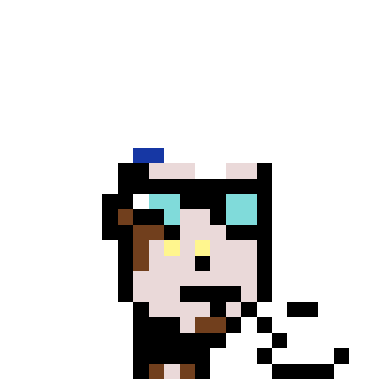

In [12]:
# Totally Random

z = torch.randn(1, latent_dims + num_labels).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


In [25]:
import json
import random

ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

label_idx = int(random.random() * len(dataset))
_, features = dataset[label_idx]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['female', 'purpleEyeShadow', 'stringyHair', 'hotLipstick', 'earring']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


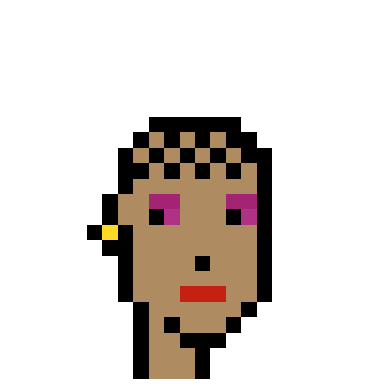

In [26]:
# Generate new image

# Random data for image side
z = torch.randn(1, latent_dims).to(device)

# Concat image with actual feature labels from dataset
z = torch.concat([z, features.unsqueeze(0)], dim=1)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)
decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Graph Losses

In [15]:
train_losses

[30782.638428600123,
 6229.306547557208,
 5074.246598480441,
 4465.738171300144,
 4125.722588288869,
 3893.921687132923,
 3727.6121919239667,
 3633.184308856937,
 3578.74078672152,
 3548.8763522966533,
 3526.0174874380127,
 3512.7638432928857,
 3505.247870911943,
 3499.169889409491,
 3492.3990391940933,
 3487.757184400626,
 3482.6079259561307,
 3481.481768668966,
 3468.611367191829,
 3450.3253329662566,
 3449.279048838514,
 3450.2739755616967,
 3446.0162955209717,
 3442.921275903147,
 3446.898554592268,
 3442.3061110043354,
 3444.792694741107,
 3446.003997369861,
 3441.81636859001,
 3441.7217493801254,
 3439.2596851105386,
 3439.671529783425,
 3440.1821102926915,
 3441.170849955674,
 3434.483942992298,
 3436.6785572674257,
 3435.917768762467,
 3426.815320819828,
 3426.5449348612033,
 3427.69498611342,
 3422.724311990941,
 3411.9652002212847,
 3409.8957108301474,
 3413.3853357193316,
 3414.1497300601177,
 3415.2203258757895,
 3411.058966670476,
 3414.4513590927663,
 3411.8536385610596,


In [16]:
test_losses

[6788.712963104248,
 5511.313491821289,
 4574.302806854248,
 4167.569381713867,
 3915.5067501068115,
 3720.988931655884,
 3602.9905071258545,
 3555.4817600250244,
 3503.9473152160645,
 3465.7743587493896,
 3450.1906929016113,
 3438.98325920105,
 3443.515031814575,
 3432.6822471618652,
 3430.2155685424805,
 3422.9181785583496,
 3435.9593353271484,
 3436.2014198303223,
 3408.008876800537,
 3378.5412940979004,
 3385.9818935394287,
 3389.112724304199,
 3386.2801570892334,
 3378.9808235168457,
 3380.7672786712646,
 3383.023542404175,
 3393.830135345459,
 3384.849672317505,
 3378.277889251709,
 3382.5414867401123,
 3382.2113704681396,
 3380.975597381592,
 3370.1947746276855,
 3376.1045455932617,
 3370.2874641418457,
 3380.726360321045,
 3373.181011199951,
 3368.1864624023438,
 3366.99654006958,
 3366.6441020965576,
 3358.4708194732666,
 3343.95717048645,
 3355.0207290649414,
 3349.314805984497,
 3359.5845317840576,
 3345.802490234375,
 3355.908966064453,
 3352.9964923858643,
 3377.3207702636

<function matplotlib.pyplot.show(close=None, block=None)>

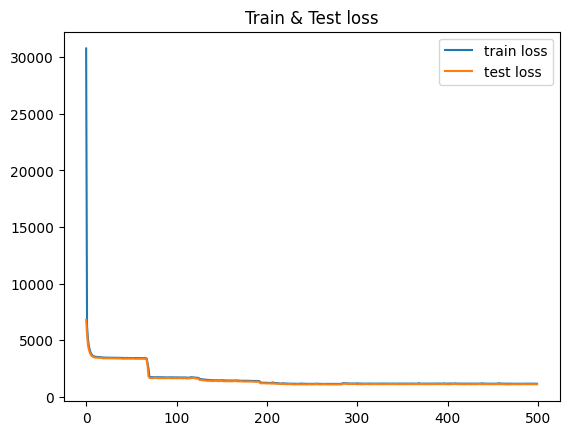

In [17]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
